In [1]:
# Basic Statistics tasks

#     Which store has maximum sales?
#     Which store has maximum standard deviation i.e., the sales vary a lot. Also, find out the coefficient of mean to standard deviation
#     Which store/s has good quarterly growth rate in Q3’2012?
#     Some holidays have a negative impact on sales. Find out holidays which have higher sales than the mean sales in non-holiday season for all stores together
#     Provide a monthly and semester view of sales in units and give insights?

# Statistical Model

# For Store 1 – Build  prediction models to forecast demand
#     Linear Regression – Utilize variables like date and restructure dates as 1 for 5 Feb 2010 (starting from the earliest date in order). Hypothesize if CPI, unemployment, and fuel price have any impact on sales.
#     Change dates into days by creating new variable.
# Select the model which gives best accuracy.

# Import libraries 
import pandas as pd
import numpy as np
import datetime
from time import time

# Import libraries | Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Import libraries | Sk-learn
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics.scorer import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

%matplotlib inline

C:\Users\jssrv\_programs\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Dataset Description

# This is the historical data that covers sales from 2010-02-05 to 2012-11-01, in the file Walmart_Store_sales. Within this file you will find the following fields:

#     Store - the store number
#     Date - the week of sales
#     Weekly_Sales -  sales for the given store
#     Holiday_Flag - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week
#     Temperature - Temperature on the day of sale
#     Fuel_Price - Cost of fuel in the region
#     CPI – Prevailing consumer price index
#     Unemployment - Prevailing unemployment rate

sells = pd.read_csv("../../../ai_algos/data/Walmart_Store_sales.csv")
print(sells.info())
print(sells.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  

In [4]:
#Change dates into days by creating new variables.
sells.Date = pd.to_datetime(sells.Date)
sells["Week"]=sells.Date.dt.week
sells["Year"]=sells.Date.dt.year
sells.head(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Year
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,17,2010
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,48,2010
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,7,2010
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,8,2010
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,18,2010
5,1,2010-12-03,1439541.59,0,57.79,2.667,211.380643,8.106,48,2010
6,1,2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,11,2010
7,1,2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,12,2010
8,1,2010-02-04,1594968.28,0,62.27,2.719,210.820450,7.808,5,2010
9,1,2010-09-04,1545418.53,0,65.86,2.770,210.622857,7.808,35,2010


In [5]:
# Which store/s has good quarterly growth rate in Q3’2012
# Some holidays have a negative impact on sales. Find out holidays which have higher sales than the mean sales in non-holiday season for all stores together
# Provide a monthly and semester view of sales in units and give insights

# Holiday Events

# Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
# Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
# Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
# Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13
Holidays = []

for i in sells.Date.dt.strftime('%Y-%m-%d'):
    if i == "2010-02-12" or i == "2011-02-11" or i=="2012-02-10" or i=="2013-02-08":
        Holidays.append(1)
    elif i == "2010-09-10" or i == "2011-09-09" or i=="2012-09-07" or i=="2013-09-06":
        Holidays.append(2)
    elif i == "2010-11-26" or i == "2011-11-25" or i=="2012-11-23" or i=="2013-11-29":
        Holidays.append(3)
    elif i == "2010-12-31" or i == "2011-12-30" or i=="2012-12-28" or i=="2013-12-27":
        Holidays.append(4) 
    else:
        Holidays.append(0)
sells['Holiday']=Holidays

[]

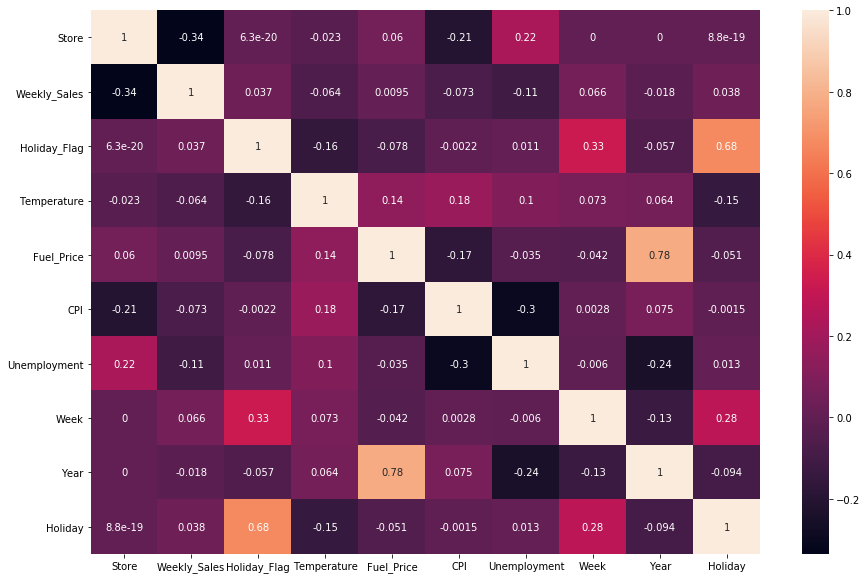

In [6]:
# Plotting correlation between all important features
corr = sells.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True)
plt.plot()

In [7]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(dataset[column] , dataset['Weekly_Sales'])
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)

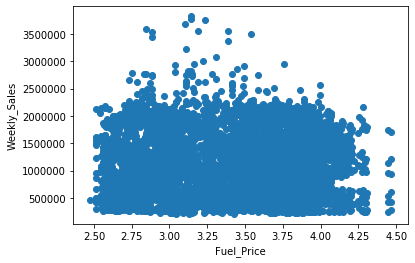

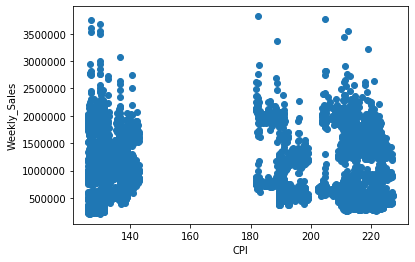

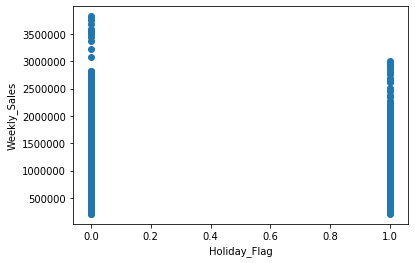

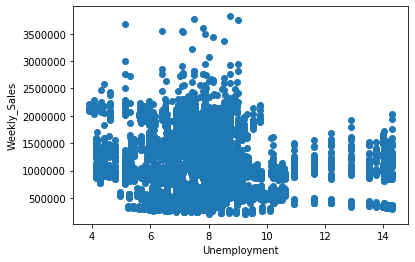

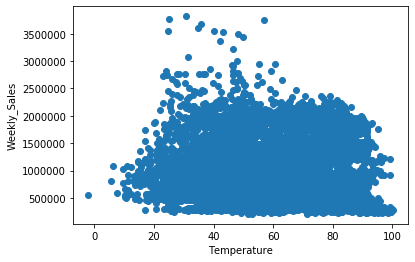

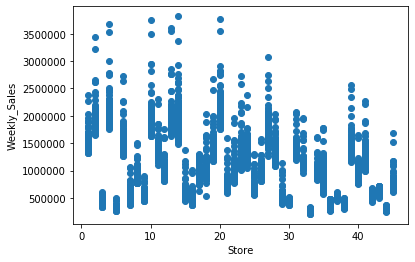

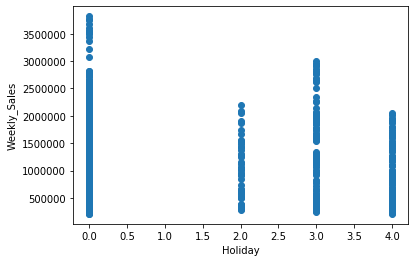

In [8]:
scatter(sells, 'Fuel_Price')
scatter(sells, 'CPI')
scatter(sells, 'Holiday_Flag')
scatter(sells, 'Unemployment')
scatter(sells, 'Temperature')
scatter(sells, 'Store')
scatter(sells,'Holiday')

In [ ]:
#from the data above, we can conclude that fuel price and temperature can be dropped
sells.drop(columns=["Holiday_Flag","Date","CPI","Fuel_Price","Temperature"],axis=1,inplace=True)
sells.head()

In [ ]:
sells.groupby('Store').describe()